## Table of contents
- [Question](#Question)
- [Data Source](#Data-Source)
- [Imports](#Imports)
- [Data Exploration](#Data-exploration-and-manipulation)
- [Visualization](#Visualizations)
- [Data Story](#Data-Story)

## Question

Tell the story of covid 19 using data provided <a href='https://data.covid19india.org/'>here</a>


## Data Source

<h4 id="v4-json-endpoints">V4 JSON endpoints<a class="anchorjs-link " href="#v4-json-endpoints" aria-label="Anchor" data-anchorjs-icon="" style="font: 1em / 1 anchorjs-icons; padding-left: 0.375em;"></a></h4>
<table>
  <thead>
    <tr>
      <th>Status</th>
      <th>Link to API</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><img class="emoji" title=":green_heart:" alt=":green_heart:" src="https://github.githubassets.com/images/icons/emoji/unicode/1f49a.png" height="20" width="20"></td>
      <td><a href="https://data.covid19india.org/v4/min/timeseries.min.json">https://data.covid19india.org/v4/min/timeseries.min.json</a></td>
      <td>Daily numbers across C,R,D and Tested per state (historical data).</td>
    </tr>
    <tr>
      <td><img class="emoji" title=":green_heart:" alt=":green_heart:" src="https://github.githubassets.com/images/icons/emoji/unicode/1f49a.png" height="20" width="20"></td>
      <td><a href="https://data.covid19india.org/v4/min/data.min.json">https://data.covid19india.org/v4/min/data.min.json</a></td>
      <td>Current day numbers across districts and states.</td>
    </tr>
  </tbody>
</table>

V4 json endpoints are the json apis that are used by the website to show all the statistics on the site. These can be used by developers and analysts who have knowledge of json parsing (recommended approach). All our v4 endpoints are actively developed and in use since this serves the frontend view <a href='https://api.covid19india.org/documentation'>Documentation for the same.</a>

Note: Please consider using the above endpoints for all your data needs. All the data we show on the website is fuelled by the above endpoints.

---

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import json
warnings.filterwarnings("ignore")

In [2]:
# import data
df = pd.read_json('https://data.covid19india.org/v4/min/timeseries.min.json')

---
## Data exploration and manipulation

In [3]:
output_list = []
# function to flatten dictionary and update output_list to convert to dataframe
def flatten_dict(input_row):
    for key in input_row['dates']:
        temp_dict = {'state': input_row['state'], 'date': key}
        if(input_row['dates'][key].get('delta')):
            temp_dict.update(input_row['dates'][key].get('delta'))
        output_list.append(temp_dict)
    return output_list

# updates the output_list to convert to dataframe
result = df.transpose().reset_index().rename(columns={'index':'state'}).apply(lambda x: flatten_dict(x), axis=1)

In [4]:
# Create DataFrame
final = pd.DataFrame(output_list)

In [5]:
final.describe()

,confirmed,recovered,tested,other,deceased,vaccinated1,vaccinated2
count,20181.000000,19440.000000,1.970700e+04,2207.000000,13978.000000,1.011900e+04,9.247000e+03
mean,3397.811010,3463.100720,6.411804e+04,11.959221,65.598798,1.445306e+05,7.136809e+04
std,17360.555174,17294.521006,2.102900e+05,50.838519,273.176465,5.458706e+05,3.038499e+05
min,-10847.000000,-13255.000000,-7.771900e+05,-266.000000,-145.000000,-1.510100e+04,-5.924600e+04
25%,36.000000,40.000000,1.948000e+03,1.000000,2.000000,2.033000e+03,1.269000e+03
50%,225.000000,236.000000,1.479800e+04,3.000000,9.000000,1.679800e+04,7.968000e+03
75%,1346.000000,1407.250000,5.497200e+04,9.000000,30.750000,9.388850e+04,4.332650e+04
max,414280.000000,422391.000000,3.740296e+06,1356.000000,6139.000000,1.348494e+07,9.398404e+06


In [6]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21678 entries, 0 to 21677
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   state        21678 non-null  object 
 1   date         21678 non-null  object 
 2   confirmed    20181 non-null  float64
 3   recovered    19440 non-null  float64
 4   tested       19707 non-null  float64
 5   other        2207 non-null   float64
 6   deceased     13978 non-null  float64
 7   vaccinated1  10119 non-null  float64
 8   vaccinated2  9247 non-null   float64
dtypes: float64(7), object(2)
memory usage: 1.5+ MB


In [7]:
final = final.fillna(0)

print('There are negtive values for numeric columns to be treated')
for i,val in enumerate(final.select_dtypes(exclude=['object']).columns):
    print('{} : {}'.format(val, (final[val]<0).sum() ))
    
print('\n filling the negative values with their previous records')
for i,val in enumerate(final[['confirmed', 'recovered', 'tested', 'deceased', 'vaccinated1', 'vaccinated2']].columns):
    final[val] = final[val].apply(lambda x : x if x >= 0 else np.nan).ffill()

There are negtive values for numeric columns to be treated
confirmed : 38
recovered : 8
tested : 33
other : 146
deceased : 12
vaccinated1 : 24
vaccinated2 : 33

 filling the negative values with their previous records


In [8]:
# deriving additional data from existing values
final = final.drop(columns=['other'])

final['confirmed_cumsum'] = final[['state','confirmed']].groupby('state').cumsum()
final['recovered_cumsum'] = final[['state','recovered']].groupby('state').cumsum()
final['tested_cumsum'] = final[['state','tested']].groupby('state').cumsum()
final['deceased_cumsum'] = final[['state','deceased']].groupby('state').cumsum()
final['vaccinated1_cumsum'] = final[['state','vaccinated1']].groupby('state').cumsum()
final['vaccinated2_cumsum'] = final[['state','vaccinated2']].groupby('state').cumsum()
final['current_positives'] = final['confirmed_cumsum'] - final['recovered_cumsum'] - final['deceased_cumsum']

final['recovery rate'] = final['recovered']/(final['current_positives'].replace(0, 1))
final['death rate'] = final['deceased']/(final['current_positives'].replace(0, 1))
final['covid positive rate'] = final['confirmed']/(final['tested'].replace(0, 1))

#### Derived features
- **current_positives** : Number of positive cases on any particular day. (Calculated using new postive cases, deaths & recoveries till that date)
- **recovery rate** : Number of recoveries per number of active cases on a day 
- **death rate** : Number of deaths per number of active cases on a day
- **covid positive rate** : Number of positive cases per number of tests made on a particular day
- Dropped __other__ column as it's missing 80% of it's values and is not clearly mentioned in the documentation
- Added cumulative numbers for each column to understand trends over time

In [9]:
final.sample(5)

,state,date,confirmed,recovered,tested,deceased,vaccinated1,vaccinated2,confirmed_cumsum,recovered_cumsum,tested_cumsum,deceased_cumsum,vaccinated1_cumsum,vaccinated2_cumsum,current_positives,recovery rate,death rate,covid positive rate
16007,PY,2021-02-16,20.0,43.0,2082.0,0.0,307.0,137.0,39488.0,38617.0,617219.0,658.0,6627.0,330.0,213.0,0.201878,0.000000,0.009606
1638,AR,2021-06-30,286.0,207.0,4782.0,4.0,12403.0,791.0,35857.0,32923.0,765890.0,172.0,509275.0,85026.0,2762.0,0.074946,0.001448,0.059808
18327,TN,2020-12-31,937.0,1038.0,68761.0,13.0,0.0,0.0,818014.0,797391.0,14191494.0,12122.0,0.0,0.0,8501.0,0.122103,0.001529,0.013627
5538,GA,2020-11-23,75.0,104.0,1460.0,0.0,0.0,0.0,46901.0,45083.0,334198.0,677.0,0.0,0.0,1141.0,0.091148,0.000000,0.051370
1254,AR,2020-06-11,6.0,0.0,444.0,0.0,0.0,0.0,64.0,4.0,13479.0,0.0,0.0,0.0,60.0,0.000000,0.000000,0.013514


In [10]:
print('min date : ' + final['date'].min())
print('max date : ' + final['date'].max())
print('data added here for {} days, missing days in between didnt have any cases reported/confirmed'.format(final['date'].nunique()))
print('range of days data was collected for so far : {}'.format( (pd.to_datetime(final['date'].max()) - pd.to_datetime(final['date'].min())).days) )
final[final['date'] == final['date'].min()]


min date : 2020-01-30
max date : 2021-10-31
data added here for 613 days, missing days in between didnt have any cases reported/confirmed
range of days data was collected for so far : 640


,state,date,confirmed,recovered,tested,deceased,vaccinated1,vaccinated2,confirmed_cumsum,recovered_cumsum,tested_cumsum,deceased_cumsum,vaccinated1_cumsum,vaccinated2_cumsum,current_positives,recovery rate,death rate,covid positive rate
9461,KL,2020-01-30,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
19206,TT,2020-01-30,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#### other data considerations
- data includes all states, 7 union terrirties & country total as state code 'TT'
- dropping other as 80% of it's data is abset and it's not clearly defined in documentation as well
- first case was confirmed on 30/01/2020 in Kerala followed by very few cases in the next one month across the country
- Most of the columns have no missing data. 

## Visualizations

In [11]:
# India wide trend, filtering total rows
final_india = final[final['state'] == 'TT'].drop(columns='state').set_index('date')

In [12]:
# set grid for all plots by default
plt.rcParams['axes.grid'] = True

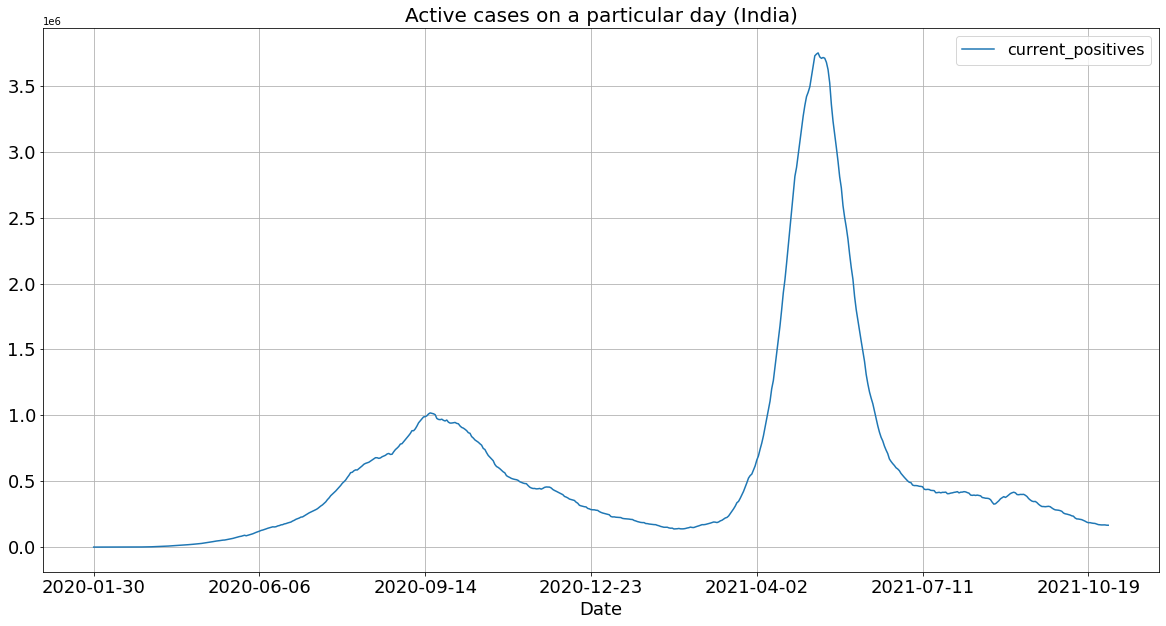

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Active cases on a particular day (India)', fontsize=20)

# Add charts on the plot one by one
final_india['current_positives'].plot(ax=ax)

# changing the fontsize of ticks & labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Date', fontsize=18)

plt.legend(fontsize=16)
# plt.grid()
plt.show() # show plot

- First covid case was reported on Jan 30th and the positive cases have seen 2 peaks since, once in September 2020 and once around May 2021. Peak active cases in india reached 35 Lakh (3.5 million) in May 2021

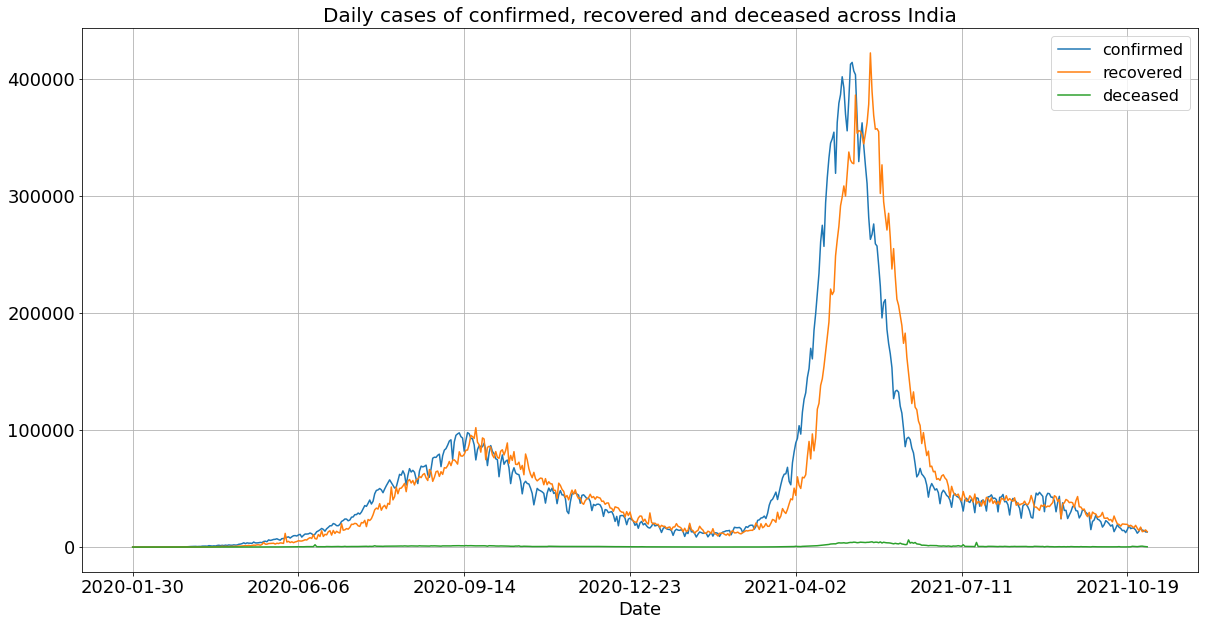

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Daily cases of confirmed, recovered and deceased across India', fontsize=20)

# Add charts on the plot one by one
final_india['confirmed'].plot(ax=ax)
final_india['recovered'].plot(ax=ax)
final_india['deceased'].plot(ax=ax)

# changing the fontsize of ticks & labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Date', fontsize=18)

plt.legend(fontsize=16)
# plt.grid()
plt.show() # show plot

In [15]:
max_cases = final_india.sort_values(by='confirmed', ascending=False).reset_index()['date'].iloc[0]
max_recoveries = final_india.sort_values(by='recovered', ascending=False).reset_index()['date'].iloc[0]
print('date of max confirmed cases: {}'.format(max_cases))
print('date of max recovered cases: {}'.format(max_recoveries))

date of max confirmed cases: 2021-05-06
date of max recovered cases: 2021-05-17


- Around 4 Lakh new cases were reported at a point of time.
- Recoveries followed the same pattern as new cases with an offset of few days.
- Maximum cases reported on 2021-05-06 and maximum recoveries on 2021-05-17, with a difference of 11 days between them, which is the average amount of days a patient takes to recover once effected by covid.


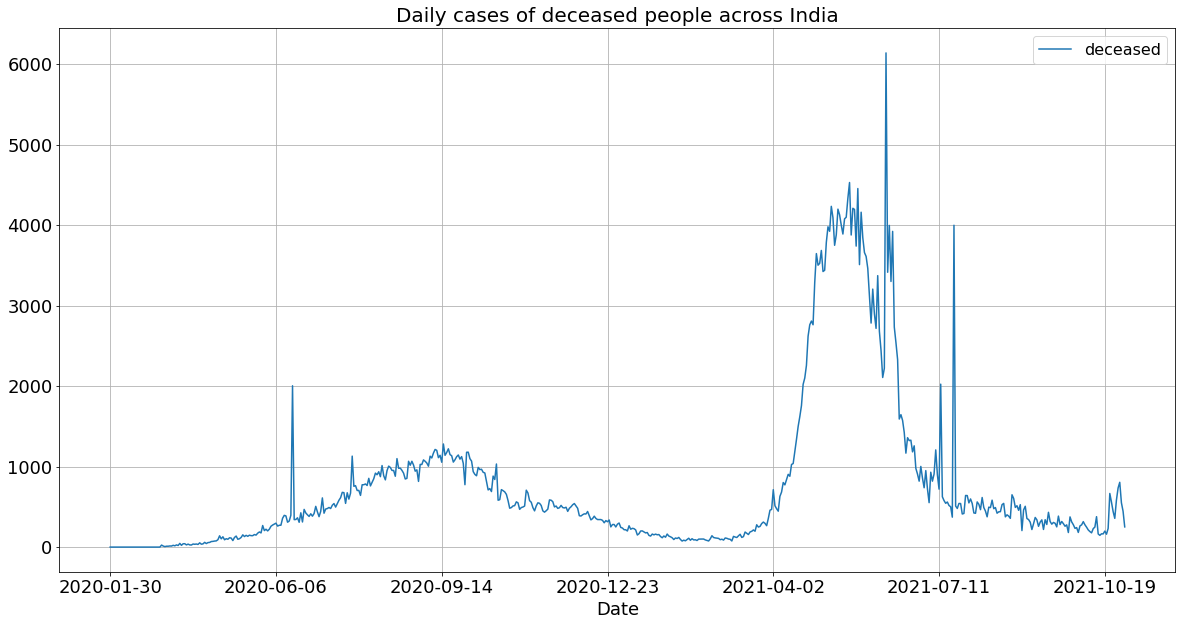

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Daily cases of deceased people across India', fontsize=20)

# Add charts on the plot one by one
final_india['deceased'].plot(ax=ax)

# changing the fontsize of ticks & labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Date', fontsize=18)

plt.legend(fontsize=16)
# plt.grid()
plt.show() # show plot

In [17]:
max_deceased = final_india.sort_values(by='deceased', ascending=False).reset_index()['date'].iloc[0]
max_deceased_count = final_india.sort_values(by='deceased', ascending=False)['deceased'].iloc[0]
max_deceased2 = final_india.sort_values(by='deceased', ascending=False).reset_index()['date'].iloc[1]
print('Maximum deaths of {} were reported on {} which is actually a spike rather than a trend. Second highest deaths were on {} which is the week we had maximum recoveries too'.format(max_deceased_count, max_deceased, max_deceased2))


Maximum deaths of 6139.0 were reported on 2021-06-09 which is actually a spike rather than a trend. Second highest deaths were on 2021-05-18 which is the week we had maximum recoveries too


The 3 sharp spikes for the above chart, one on Jun 2020, one on Jun 2021 and one in July 2021 are due to offbeat cases where extraordinary number of deaths were reported in particular states like, in delhi for the first spike on Jun 2020 and bihar for the second one on Jun 2021.

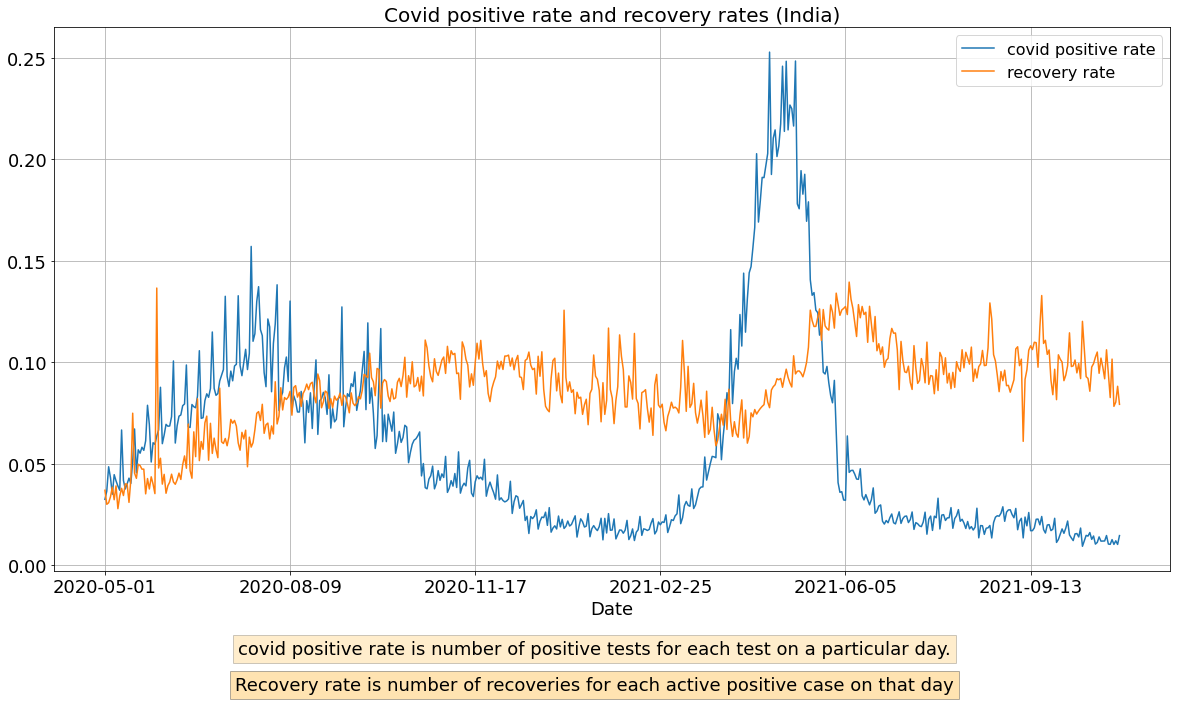

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Covid positive rate and recovery rates (India)', fontsize=20)

# Add charts on the plot one by one
final_india[(final_india.index >= '2020-05-01')]['covid positive rate'].plot(ax=ax)
final_india[(final_india.index >= '2020-05-01')]['recovery rate'].plot(ax=ax)
# final_india['recovery rate'].plot(ax=ax)

# changing the fontsize of ticks & labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Date', fontsize=18)

plt.figtext(0.5, 0.01, "covid positive rate is number of positive tests for each test on a particular day.", ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
plt.figtext(0.5, -0.04, "Recovery rate is number of recoveries for each active positive case on that day", ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.3, "pad":5})

plt.legend(fontsize=16)
# plt.grid()
plt.show() # show plot

- Spike around April - May 2021 for **covid postive rate**. Lot of tests were done around this time and ratio of positive cases for each test has increased dramatically too, due to severe transmission
- Recovery rate has remained almost stable till peak covid and improved slightly since. One of my hypothesis for this is increased awareness of the situation due to the peak preceeding it.
- Both trends had slow start as expected. Covid needs some time to transmit to people and so covid rate increased gradually since. Recovery is difficult with a new virus in the country we were not prepared for.

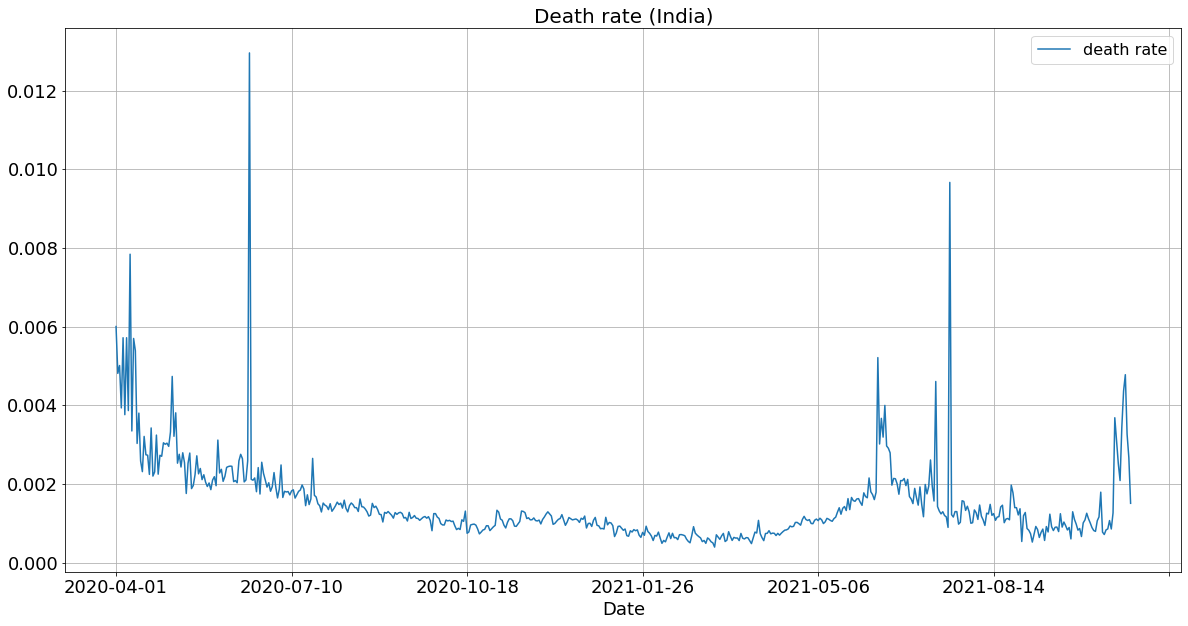

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Death rate (India)', fontsize=20)

# Add charts on the plot one by one
final_india[(final_india.index >= '2020-04-01')]['death rate'].plot(ax=ax)

# changing the fontsize of ticks & labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Date', fontsize=18)

plt.legend(fontsize=16)
# plt.grid()
plt.show() # show plot

- Almost constant death rate with not so considerable change in pattern and few spikes, reasons for which i mentioned previously. i.e due to offbeat deaths reported in specific states likes bihar and delhi on those days

###  Vaccinations

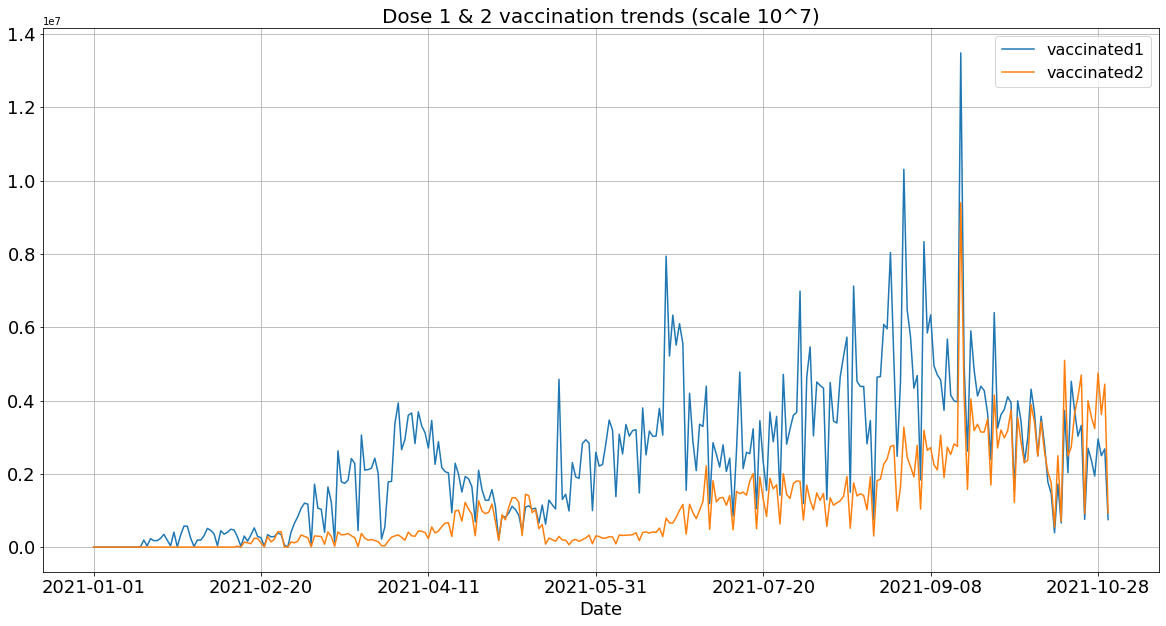

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Dose 1 & 2 vaccination trends (scale 10^7)', fontsize=20)

final_india[final_india.index >= '2021-01-01']['vaccinated1'].plot(ax=ax)
final_india[final_india.index >= '2021-01-01']['vaccinated2'].plot(ax=ax)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Date', fontsize=18)

plt.legend(fontsize=16)
# plt.grid()
plt.show()

- Vaccinations started in January 2020
- The periodical dips and spikes for both doses are on sundays and mondays respectively with a dip on sundays and spike followed immediately

### Monthly aggregates

In [21]:
# aggregate to monthly level
india_agg = final_india.reset_index()
india_agg['year_month'] = pd.to_datetime(india_agg['date']).dt.strftime('%Y-%m')
india_agg = india_agg.groupby(by='year_month').agg({'confirmed': 'sum', 'recovered': 'sum', 'tested': 'sum', 'deceased': 'sum', 'vaccinated1': 'sum', 'vaccinated2': 'sum'})


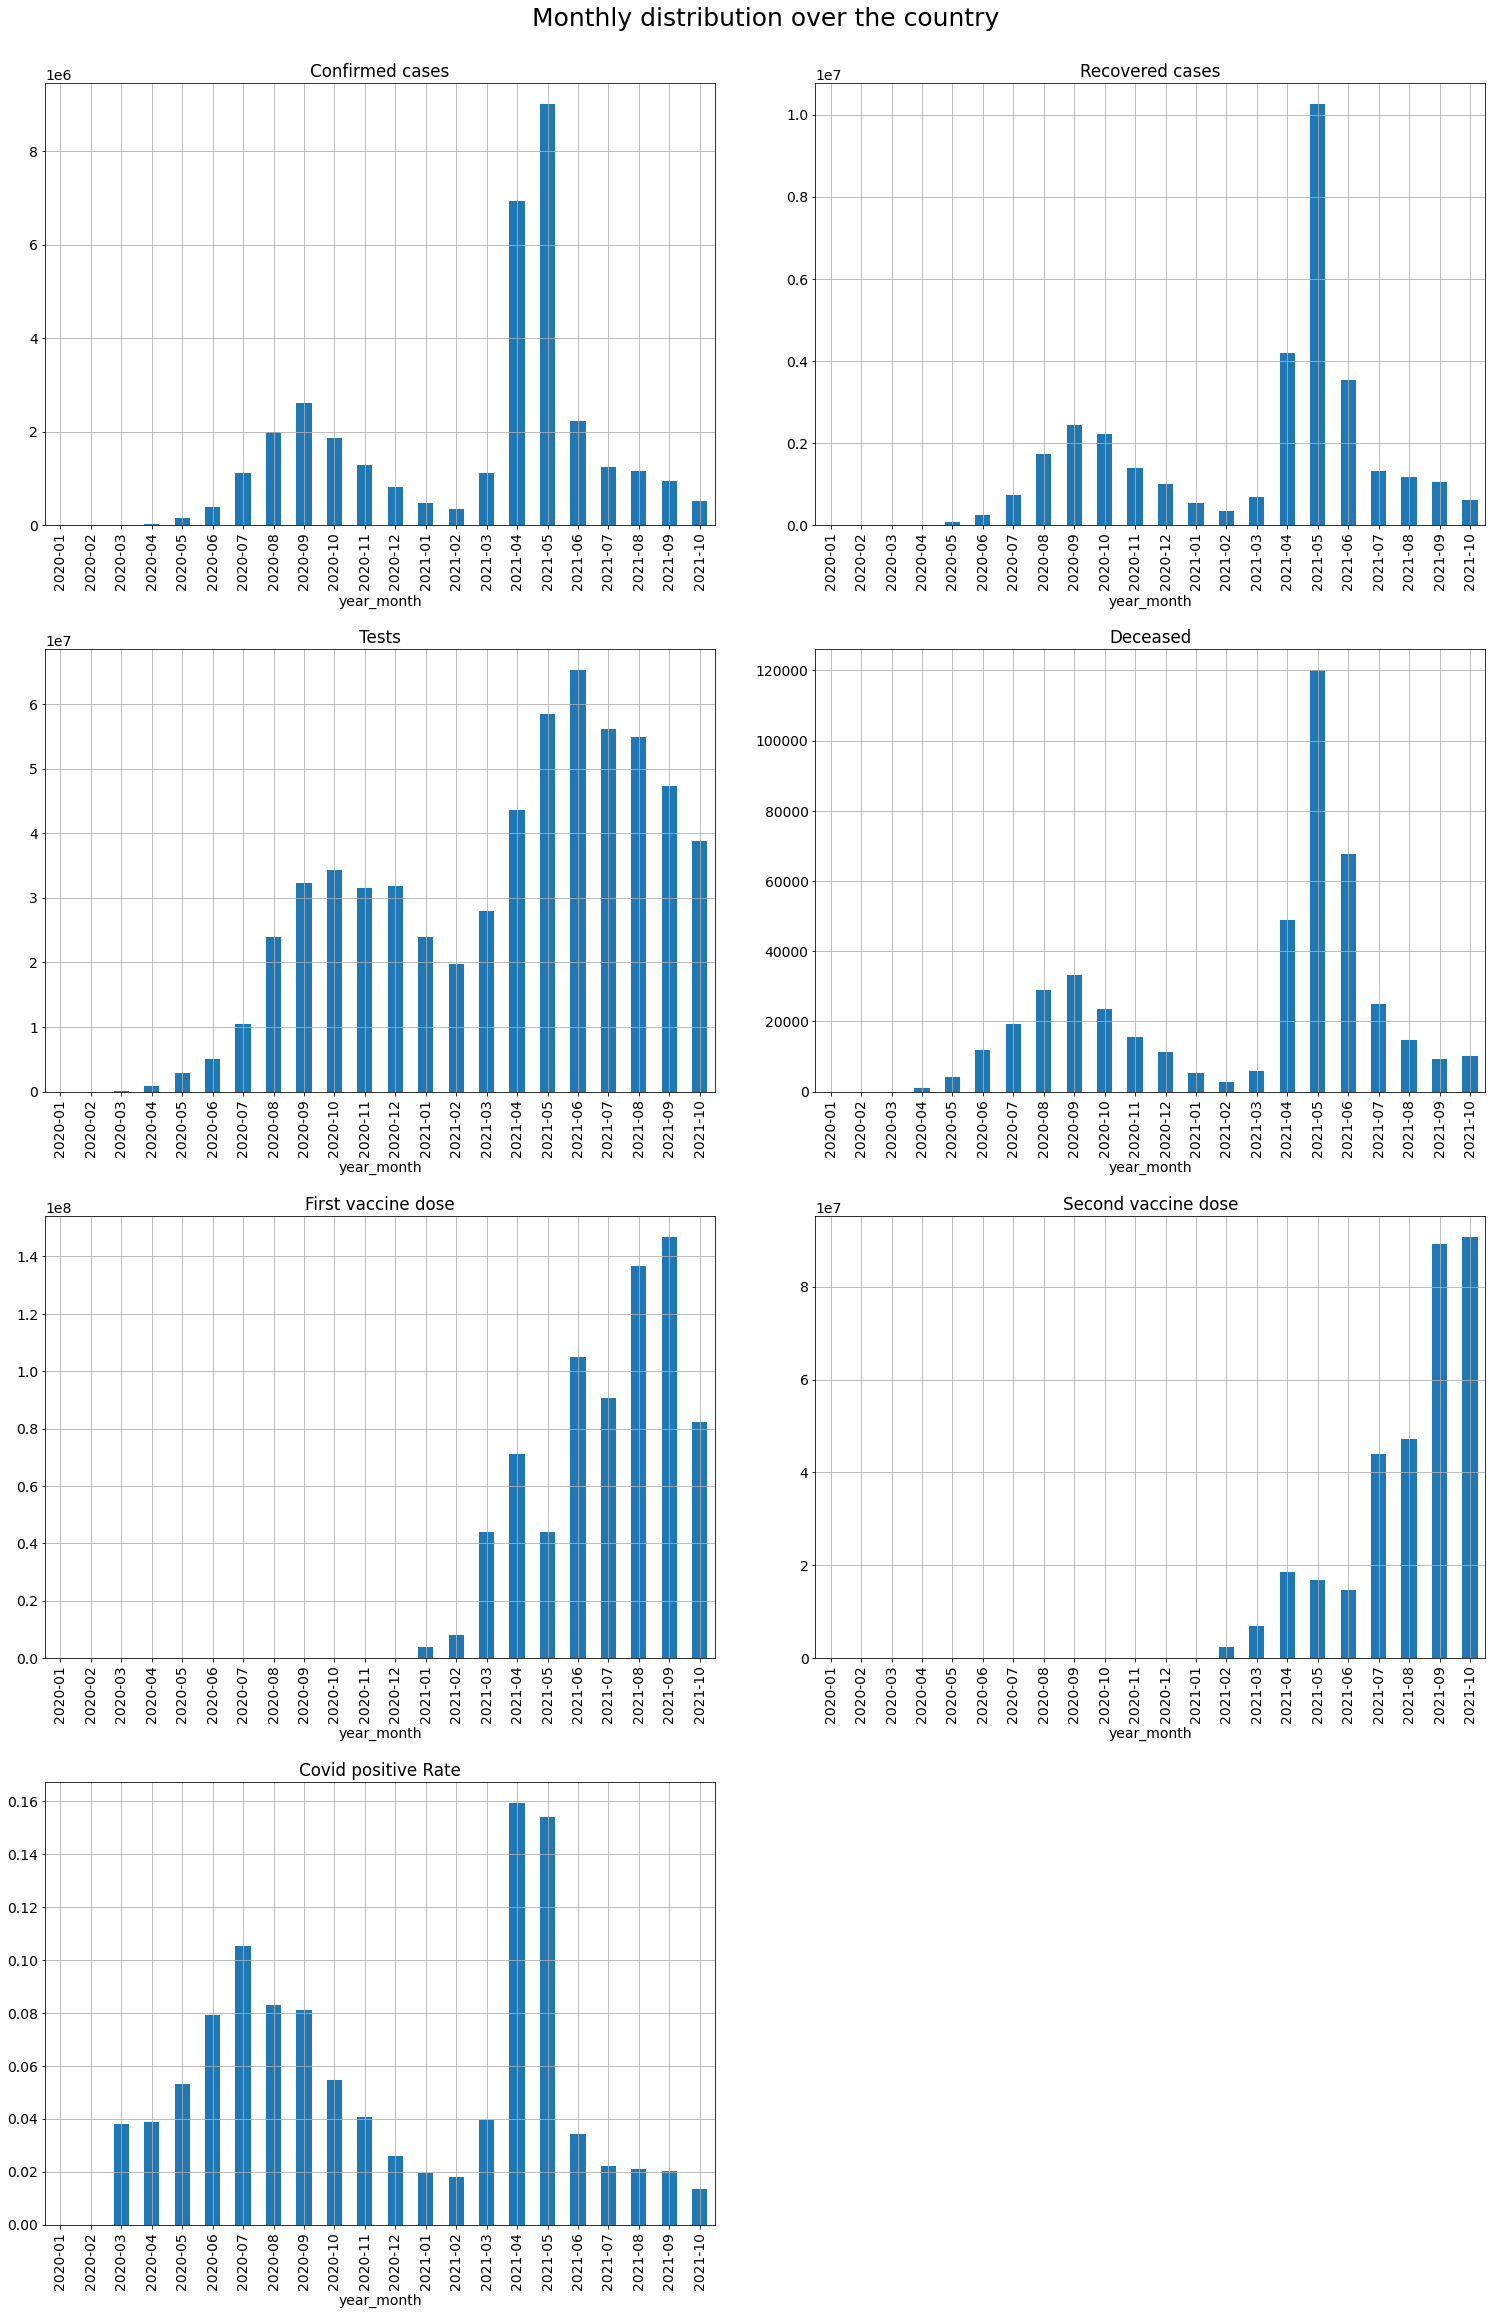

In [22]:
fig = plt.figure(figsize = (20,35))
plt.rcParams.update({'font.size': 14})

ax1 = fig.add_subplot(4,2,1, title="Confirmed cases")
ax2 = fig.add_subplot(4,2,2, title="Recovered cases")
ax3 = fig.add_subplot(4,2,3, title="Tests")
ax4 = fig.add_subplot(4,2,4, title="Deceased")
ax5 = fig.add_subplot(4,2,5, title="First vaccine dose")
ax6 = fig.add_subplot(4,2,6, title="Second vaccine dose")
ax7 = fig.add_subplot(4,2,7, title="Covid positive Rate")

india_agg['confirmed'].plot(kind='bar', ax=ax1)
india_agg['recovered'].plot(kind='bar', ax=ax2)
india_agg['tested'].plot(kind='bar', ax=ax3)
india_agg['deceased'].plot(kind='bar', ax=ax4)
india_agg['vaccinated1'].plot(kind='bar', ax=ax5)
india_agg['vaccinated2'].plot(kind='bar', ax=ax6)
(india_agg['confirmed']/india_agg['tested']).plot(kind='bar', ax=ax7)

plt.suptitle('Monthly distribution over the country', fontsize=25)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.95, wspace=0.15, hspace=0.28)
plt.show()

- Confirmed cases, recoveries and deaths peaked on May 2021. **April, May and June of 2021 was the toughest period** which involved lockdowns on central and state level to mitigate the covid effects to some extent.
- Covid tests almost doubled in April 2021 which is a factor leading to increase in the confirmed positive cases. But the covid positive rate (positives tested of each test) **increased by 4 fold** which shows the seriousness of situation around this time ( as can be seen in 2021-04 & 2021-05 of **Graph 5 - Covid Positive Rate**)

In [23]:
final.columns

Index(['state', 'date', 'confirmed', 'recovered', 'tested', 'deceased',
       'vaccinated1', 'vaccinated2', 'confirmed_cumsum', 'recovered_cumsum',
       'tested_cumsum', 'deceased_cumsum', 'vaccinated1_cumsum',
       'vaccinated2_cumsum', 'current_positives', 'recovery rate',
       'death rate', 'covid positive rate'],
      dtype='object')

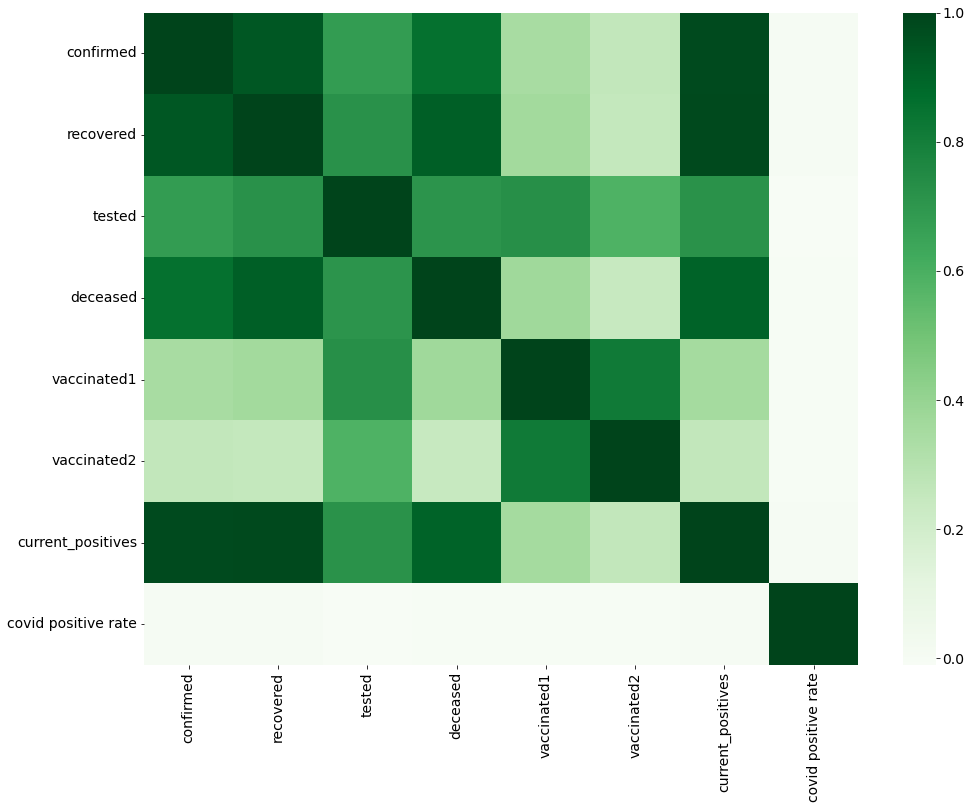

In [24]:
corr = final.drop(columns=['confirmed_cumsum', 'recovered_cumsum', 'tested_cumsum', 'deceased_cumsum', 'vaccinated1_cumsum', 'vaccinated2_cumsum', 'recovery rate', 'death rate']).loc[:,final.dtypes == 'float64'].corr()
f, ax = plt.subplots(figsize=(16, 12))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='Greens')

Few observations here include:
- Strong correlation between positive cases, recoveries, deaths and tests to some extent.
- positive correlation between vaccinated 1 and 2 which is an expected result. Trend for this can be seen in previous bar chart too.

### Statewise distribution

In [25]:
state_df_agg = final.copy()
state_df_agg['year_month'] = pd.to_datetime(state_df_agg['date']).dt.strftime('%Y-%m')
state_df_agg = state_df_agg.groupby(by=['state', 'year_month']).agg({'confirmed': 'sum', 'recovered': 'sum', 'tested': 'sum', 'deceased': 'sum', 'vaccinated1': 'sum', 'vaccinated2': 'sum'}).reset_index()

In [26]:
final_india.nlargest(5, 'current_positives')

,confirmed,recovered,tested,deceased,vaccinated1,vaccinated2,confirmed_cumsum,recovered_cumsum,tested_cumsum,deceased_cumsum,vaccinated1_cumsum,vaccinated2_cumsum,current_positives,recovery rate,death rate,covid positive rate
date,,,,,,,,,,,,,,,,
2021-05-09,366455.0,353777.0,1474606.0,3749.0,424323.0,312617.0,22662546.0,18665464.0,303750077.0,246148.0,134404867.0,35771736.0,3750934.0,0.094317,0.000999,0.248510
2021-05-08,403808.0,386395.0,1865428.0,4092.0,868098.0,1225021.0,22296091.0,18311687.0,302275471.0,242399.0,133980544.0,35459119.0,3742005.0,0.103259,0.001094,0.216469
2021-05-07,406901.0,327675.0,1808344.0,4233.0,1024622.0,1348864.0,21892283.0,17925292.0,300410043.0,238307.0,133112446.0,34234098.0,3728684.0,0.087880,0.001135,0.225013
2021-05-10,329491.0,355930.0,1850110.0,3879.0,1089607.0,1443856.0,22992037.0,19021394.0,305600187.0,250027.0,135494474.0,37215592.0,3720616.0,0.095664,0.001043,0.178093
2021-05-12,362632.0,352005.0,1864594.0,4128.0,1038646.0,939619.0,23703224.0,19728797.0,309448585.0,258353.0,137658380.0,39555876.0,3716074.0,0.094725,0.001111,0.194483


#### Top 8 states (by active cases) trends across the timeline

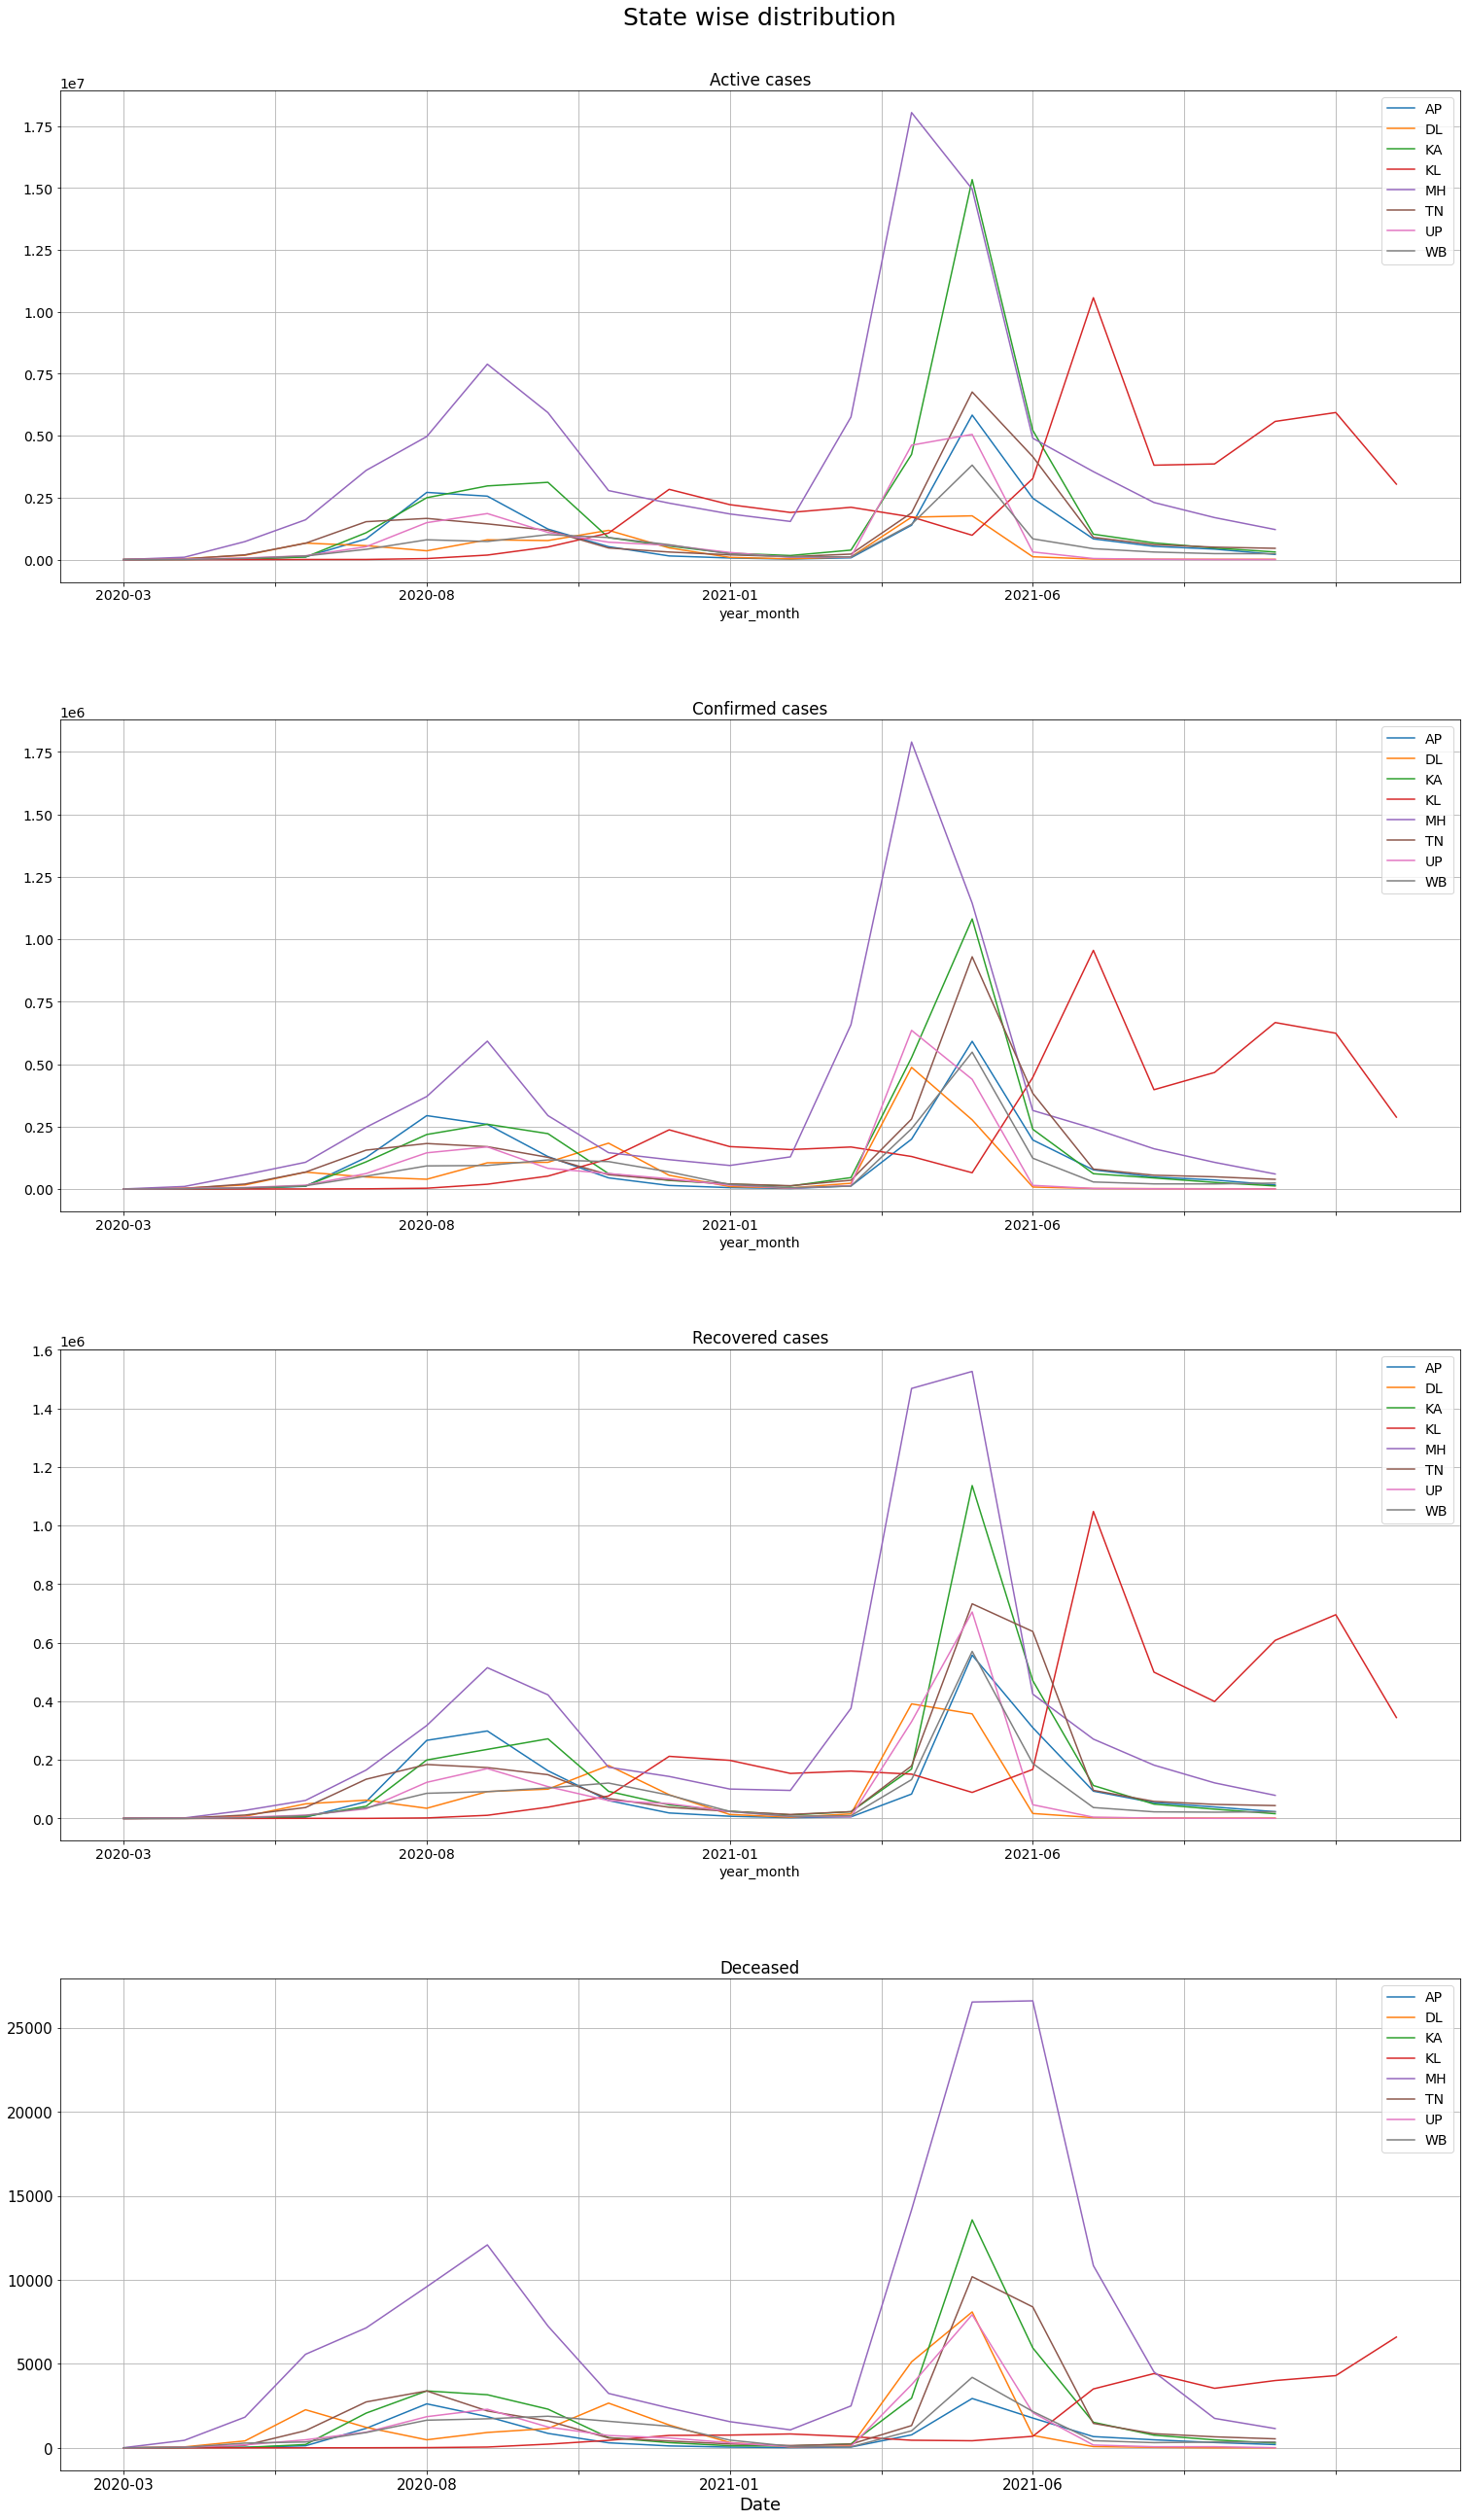

In [27]:
state_df_agg = final.copy()
state_df_agg['year_month'] = pd.to_datetime(state_df_agg['date']).dt.strftime('%Y-%m')
state_df_agg = state_df_agg.groupby(by=['state', 'year_month']).agg({'confirmed': 'sum', 'recovered': 'sum', 'tested': 'sum', 'deceased': 'sum', 'current_positives': 'sum', 'vaccinated1': 'sum', 'vaccinated2': 'sum'}).reset_index()

temp_df = state_df_agg[(state_df_agg['state'] != 'TT')][['state', 'confirmed', 'recovered', 'deceased', 'vaccinated1', 'vaccinated2', 'year_month', 'current_positives']]

severe_states = temp_df.groupby(by='state').agg({'confirmed':'sum'}).sort_values(by='confirmed', ascending=False).head(8).index
temp_df = temp_df[state_df_agg['state'].isin(severe_states)]

# plotting top 8 states by cases confirmed 
fig = plt.figure(figsize = (20,40))
ax0 = fig.add_subplot(4,1,1, title="Active cases")
ax1 = fig.add_subplot(4,1,2, title="Confirmed cases")
ax2 = fig.add_subplot(4,1,3, title="Recovered cases")
ax3 = fig.add_subplot(4,1,4, title="Deceased")

temp_df.set_index('year_month').groupby('state')['current_positives'].plot(ax=ax0, legend=True)
temp_df.set_index('year_month').groupby('state')['confirmed'].plot(ax=ax1, legend=True)
temp_df.set_index('year_month').groupby('state')['recovered'].plot(ax=ax2, legend=True)
temp_df.set_index('year_month').groupby('state')['deceased'].plot(ax=ax3, legend=True)

plt.suptitle('State wise distribution', fontsize=25)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.95, wspace=0.15, hspace=0.28)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date', fontsize=18)

plt.legend(fontsize=14)
plt.show()


- Maharashtra has more active cases and deaths compared to any other state
- All these states had 2 peaks for cases and deaths but Kerala had delayed peaks compared to rest of the states.

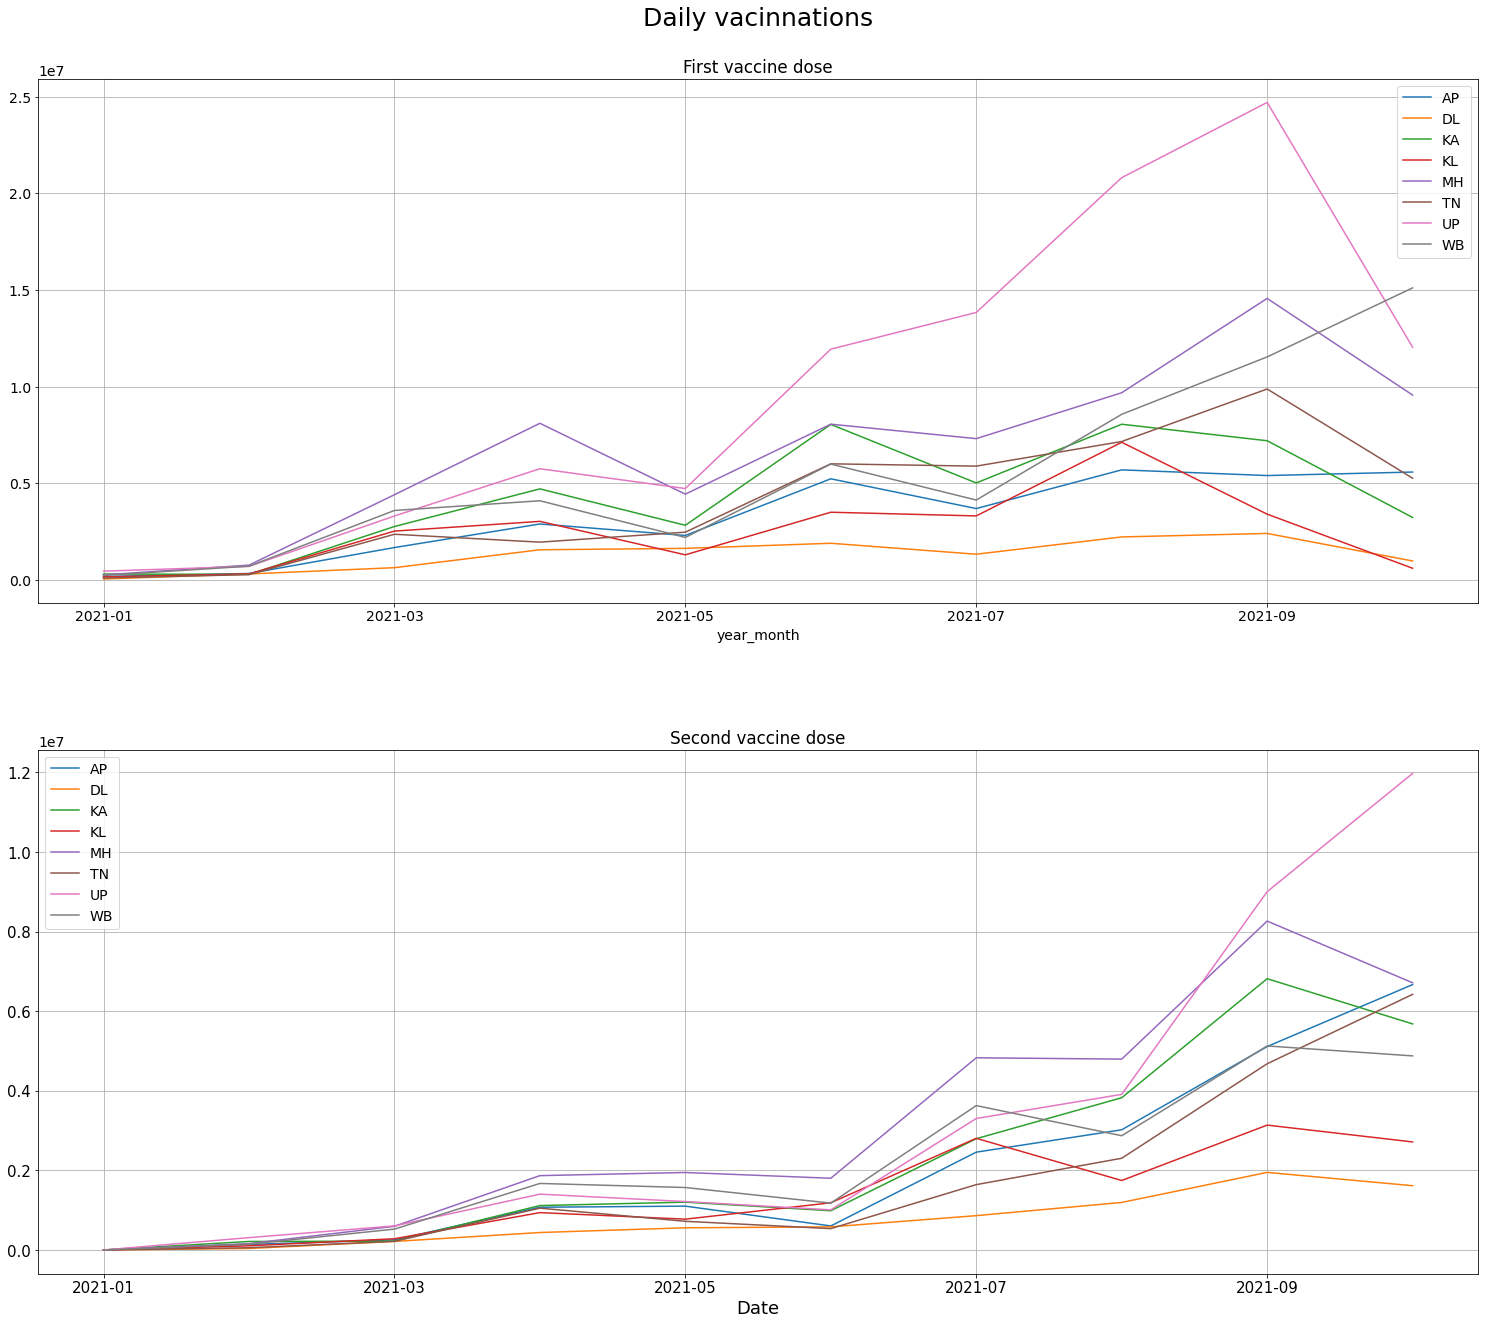

In [28]:
# state_df_agg = final.copy()
# state_df_agg['year_month'] = pd.to_datetime(state_df_agg['date']).dt.strftime('%Y-%m')
# state_df_agg = state_df_agg.groupby(by=['state', 'year_month']).agg({'confirmed': 'sum', 'recovered': 'sum', 'tested': 'sum', 'deceased': 'sum', 'vaccinated1': 'sum', 'vaccinated2': 'sum'}).reset_index()

temp_df = state_df_agg[(state_df_agg['year_month'] >= '2021-01') & (state_df_agg['state'] != 'TT')][['state', 'confirmed', 'recovered', 'deceased', 'vaccinated1', 'vaccinated2', 'year_month']]

severe_states = temp_df.groupby(by='state').agg({'confirmed':'sum'}).sort_values(by='confirmed', ascending=False).head(8).index
temp_df = temp_df[state_df_agg['state'].isin(severe_states)]

# plotting top 8 states by cases confirmed 
fig = plt.figure(figsize = (20,20))
ax4 = fig.add_subplot(2,1,1, title="First vaccine dose")
ax5 = fig.add_subplot(2,1,2, title="Second vaccine dose")

temp_df.set_index('year_month').groupby('state')['vaccinated1'].plot(ax=ax4, legend=True)
temp_df.set_index('year_month').groupby('state')['vaccinated2'].plot(ax=ax5, legend=True)

plt.suptitle('Daily vacinnations', fontsize=25)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.93, wspace=0.15, hspace=0.28)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date', fontsize=18)

plt.legend(fontsize=14)
plt.show()


- Vaccinations started taking pace in February 2021
- UP and Maharashtra lead in vaccinations due to their high population. 
- UP is lagging in second dose compared to Maharshtra when you take population and first dose numbers into consideration

## miscellaneous data

In [29]:
# https://data.covid19india.org/csv/latest/statewise_tested_numbers_data.csv -> majority data missing
# http://data.covid19india.org/csv/latest/icmr_rtpcr_tests_daily.csv -> daily tests info, already available in aggregated format in earlier data
# http://data.covid19india.org/csv/latest/vaccine_doses_statewise_v2.csv -> available in previous data on aggregation

# miscellaneous data
state_tests = pd.read_csv('https://data.covid19india.org/csv/latest/statewise_tested_numbers_data.csv')

In [30]:
print('shape : {}'.format(state_tests.shape))

# picking few important features from these
state_tests = state_tests[['Updated On', 'State', 'RT-PCR Test(Includes TrueNat,CBNAAT,CRISPR)', 'RAT(Rapid Antigen Test)',
      'Total Tested', 'Positive', 'Negative', 'Unconfirmed', 'Total People Quarantined', 'People on ICU Beds',
      'People on Ventilator', 'People on O2 Beds', 'Beds Occupied(Normal/Isolation)', 'Total Num ICU Beds',
      'Total Num Ventilators', 'Total Num of O2 Beds', 'Total Num Beds (Normal/Isolation) ', 'Total PPE',
      'Total N95 Masks', 'COVID Enquiry Calls']]
(100*state_tests.notnull().sum()/len(state_tests)).sort_values(ascending=False)

shape : (19211, 53)


Updated On                                     100.000000
State                                          100.000000
Total Tested                                    99.823018
Negative                                        36.682109
Positive                                        29.613242
Unconfirmed                                     22.934777
RT-PCR Test(Includes TrueNat,CBNAAT,CRISPR)     22.273697
RAT(Rapid Antigen Test)                         19.499245
Total Num Beds (Normal/Isolation)               16.136588
Beds Occupied(Normal/Isolation)                 11.972308
People on Ventilator                            10.306595
Total Num ICU Beds                               9.452918
People on ICU Beds                               8.771017
Total Num Ventilators                            8.203633
Total People Quarantined                         7.120920
Total PPE                                        5.554110
Total N95 Masks                                  5.554110
People on O2 B

Peeped into this data to find out the availability and occupancy of beds/ventillators, Masks, Ventilators etc across states to find the "state health factor" and severeity to some extent. But most of the data here is missing. So ignoring this data for any further analysis as the data available is not sufficient/concrete to look for any patterns

### Scraping latest population info

In [31]:
# pip install lxml html5lib beautifulsoup4
url = 'https://statisticstimes.com/demographics/india/indian-states-population.php'
dfs = pd.read_html(url)
print('no of tables from the url : {}'.format(len(dfs)))

no of tables from the url : 2


In [32]:
population = dfs[1].droplevel(0, axis=1)
population.head()

,Rank,State/UT,2019,2011,Absolute,%,2019,Country,W rank
0,NCT,Delhi,18710922,16787941,1922981,11.45,1.36,Malawi,63
1,18,Haryana,28204692,25351462,2853230,11.25,2.06,Venezuela,51
2,14,Kerala,35699443,33406061,2293382,6.87,2.60,Morocco,41
3,20,Himachal Pradesh,7451955,6864602,587353,8.56,0.54,"China, Hong Kong SAR",104
4,16,Punjab,30141373,27743338,2398035,8.64,2.20,Mozambique,48


In [33]:
# Removing all columns bar state and population
population = population.iloc[:, [1, 2]]

In [34]:
url = 'https://kb.bullseyelocations.com/article/60-india-state-codes'
codes = pd.read_html(url)
codes[0].columns = codes[0].iloc[0]
codes = codes[0][1:]
codes.head()

,State Name,Abbreviation,Alternate Abbreviation
1,Andaman and Nicobar Islands,AN,IN-AN
2,Andhra Pradesh,AP,IN-AP
3,Arunachal Pradesh,AR,IN-AR
4,Assam,AS,IN-AS
5,Bihar,BR,IN-BR


In [35]:
final_totals = final[['state', 'confirmed', 'recovered', 'tested', 'deceased', 'vaccinated1', 'vaccinated2']].groupby(by='state').sum()
final_totals.head()

,confirmed,recovered,tested,deceased,vaccinated1,vaccinated2
state,,,,,,
AN,7651.0,7518.0,599378.0,129.0,294001.0,200683.0
AP,2066450.0,2047722.0,29518787.0,14373.0,33045070.0,20431453.0
AR,55155.0,54774.0,1195857.0,280.0,771875.0,534982.0
AS,610645.0,600974.0,24712042.0,5997.0,20172463.0,8068795.0
BR,726098.0,720237.0,50531824.0,9661.0,49874828.0,18370416.0


In [36]:
joined = pd.merge(population, codes, how='left', left_on='State/UT', right_on='State Name')
joined.at[(joined['State/UT'] == 'Jammu & Kashmir'),'Abbreviation'] = 'JK'
joined = joined[['Abbreviation', '2019']].rename(columns={'2019': 'population_2019'})
joined = pd.merge(final_totals.reset_index(), joined, how='inner', left_on='state', right_on='Abbreviation').drop(columns='Abbreviation')
joined.head()


,state,confirmed,recovered,tested,deceased,vaccinated1,vaccinated2,population_2019
0,AP,2066450.0,2047722.0,29518787.0,14373.0,33045070.0,20431453.0,53903393
1,AR,55155.0,54774.0,1195857.0,280.0,771875.0,534982.0,1570458
2,AS,610645.0,600974.0,24712042.0,5997.0,20172463.0,8068795.0,35607039
3,BR,726098.0,720237.0,50531824.0,9661.0,49874828.0,18370416.0,124799926
4,CH,65351.0,64495.0,795470.0,820.0,927694.0,546981.0,1158473


In [37]:
joined['confirmed ratio'] = 100*joined['confirmed']/joined['population_2019']
joined['recovered ratio'] = 100*joined['recovered']/joined['population_2019']
joined['tested ratio'] = 100*joined['tested']/joined['population_2019']
joined['death ratio'] = 100*joined['deceased']/joined['population_2019']
joined['vaccinated1 ratio'] = 100*joined['vaccinated1']/joined['population_2019']
joined['vaccinated2 ratio'] = 100*joined['vaccinated2']/joined['population_2019']
joined.set_index('state', inplace=True)

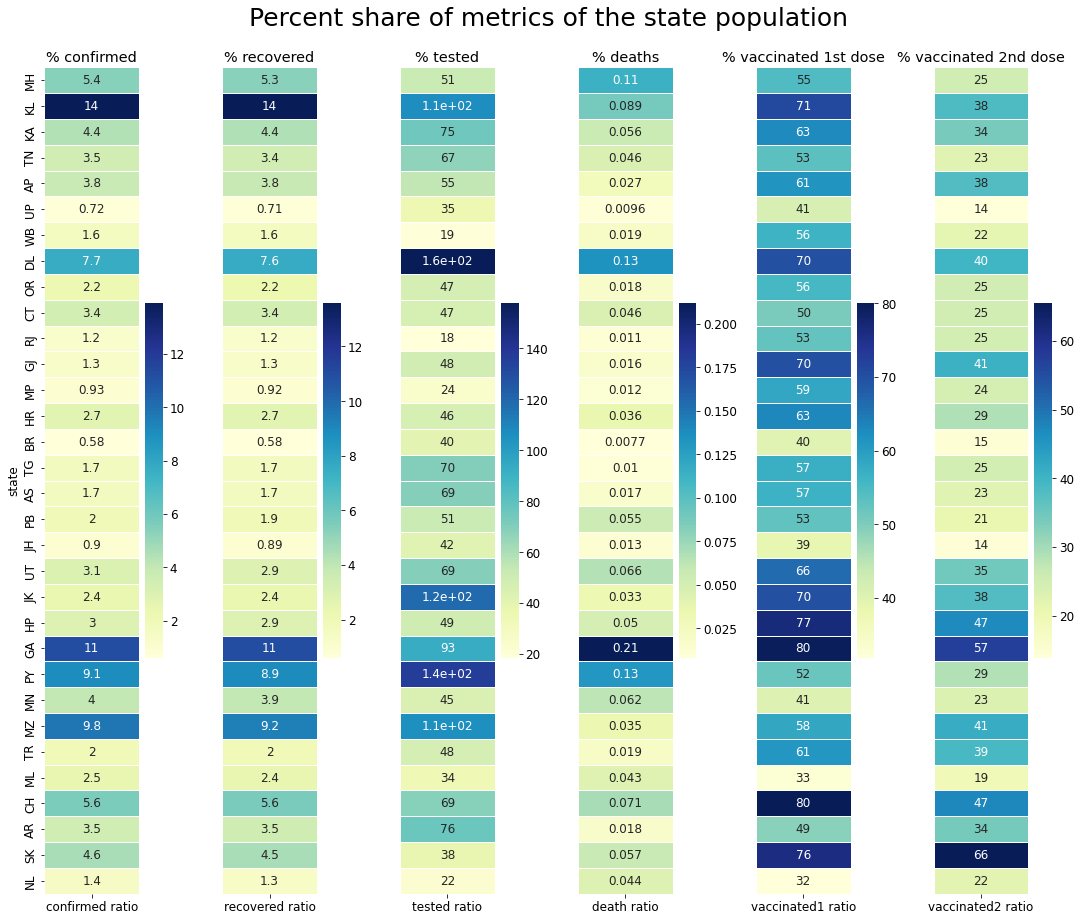

In [38]:
all_states = joined[['confirmed', 'confirmed ratio', 'recovered ratio', 'death ratio', 'tested ratio', 'vaccinated1 ratio', 'vaccinated2 ratio']][joined.index!= 'LD'].sort_values(by='confirmed', ascending=False)

# Add subplots for each column
fig = plt.figure(figsize = (14,14))
plt.rcParams.update({'font.size': 12})

ax1 = fig.add_subplot(1,6,1, title="% confirmed")
ax2 = fig.add_subplot(1,6,2, title="% recovered")
ax3 = fig.add_subplot(1,6,3, title="% tested")
ax4 = fig.add_subplot(1,6,4, title="% deaths")
ax5 = fig.add_subplot(1,6,5, title="% vaccinated 1st dose")
ax6 = fig.add_subplot(1,6,6, title="% vaccinated 2nd dose")

ax2.yaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax4.yaxis.set_visible(False)
ax5.yaxis.set_visible(False)
ax6.yaxis.set_visible(False)

# sns.heatmap(joined[['tested ratio', 'vaccinated1 ratio', 'vaccinated2 ratio']], annot=True, linewidths=.5, cmap="YlGnBu", ax=ax1)
sns.heatmap(all_states[['confirmed ratio']], annot=True, linewidths=.5, cmap="YlGnBu", ax=ax1)
sns.heatmap(all_states[['recovered ratio']], annot=True, linewidths=.5, cmap="YlGnBu", ax=ax2)
sns.heatmap(all_states[['tested ratio']], annot=True, linewidths=.5, cmap="YlGnBu", ax=ax3)
sns.heatmap(all_states[['death ratio']], annot=True, linewidths=.5, cmap="YlGnBu", ax=ax4)
sns.heatmap(all_states[['vaccinated1 ratio']], annot=True, linewidths=.5, cmap="YlGnBu", ax=ax5)
sns.heatmap(all_states[['vaccinated2 ratio']], annot=True, linewidths=.5, cmap="YlGnBu", ax=ax6)

plt.suptitle('Percent share of metrics of the state population', fontsize=25)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.92, wspace=0.5, hspace=0.3)
plt.show()


### Severity and vaccination rates across states
- Around 14% of total state population in Kerala was effected by covid, highest of any state followed by goa at 11%. UP and bihar has just 0.6 - 0.7% of population effected.
- The recovery cases are almost the same as active cases for all states as the scale of deaths is insignificant compared to patients infected by covid.
- 160% of the population of delhi had covid tests. A person might get tested multiple times and so the share is > 100. West Bengal and Rajasthan are least in the category at just 19% (Doesn't necessarily mean 19% of population got tested, but rather a measure of how prevalent covid tests were in the state).
- Goa had highest percent of deaths at 0.21 followed by delhi and pondicherry at 0.13% of its population. UP,  Telangana, MP, Gujarat, Rajasthan have low death percentages.
- Goa, Chattishgarh, Sikkim, Delhi, Himachal, Kerala, J&K have all had around 70-80% of their population taking their first vaccine dose.
- Only sikkim and goa had more than half their population taking second dose of vaccine. 
- UP, Bihar, Jharkhand had low positive cases, low deaths and low vaccine shots reported too. Could be that numbers were not reported well implicitly or explicitly. There's a high chance that numbers are not well reported in a huge country like india where system to monitor may not be the best in the world.

## Data Story
* First covid case was reported on **Jan 30th in Kerala.** 
* Covid positive cases have seen 2 peaks so far, once in September 2020 and once around May 2021. **Peak active cases in india reached 37.5 Lakhs (3.75 million) in 9th May 2021 and highest daily new cases of 4 Lakh were reported on 2021-05-06**, maximum recoveries on 2021-05-17, with a difference of 11 days between them, which is the average amount of days a patient takes to recover once effected by covid.
* highest deaths were reported on 2021-05-18 which is the week we had maximum recoveries too
* **Vaccinations started picking pace in February 2020**. Monday has seen highest vaccine doses and least on sundays almost every week
* **April, May and June of 2021 was the toughest period with 1-3 lakh new positive cases reported every day and deaths reaching around 3000 a day**. Covid tests almost doubled in April 2021 which is a factor leading to increase in the confirmed positive cases. But the covid positive rate (positives tested of each test) increased by 4 fold which shows the seriousness of situation around this time
* **Maharashtra had more positive cases and deaths compared to any other state**
* Kerala had delayed positive cases, recoveries and deaths peak compared to other states. 
* Around **14% of total state population in Kerala was effected by covid causing 0.09% deaths**. Many other states with lower positive cases share had higher death share (eg: goa / delhi / pondicherry) compared to Kerala. Government might have been well prepared for the situation and the delayed peaks might partly be the reason too.
* Goa had highest percent of deaths with **0.21% of the state population** losing their lives to the virus 